In [2]:
import scipy.special as sp
import math as ma
import numpy as np
import scipy.stats as st
import numba as nb
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
import bayessplicedmodels as bsm
from joblib import Parallel, delayed

# Burr distribution

$X\sim\text{Burr}(\alpha, \beta, \sigma)$ with pdf

$$
f(x) = \frac{\alpha\beta\sigma^{\alpha\beta}x^{\beta-1}}{(\sigma^\beta +x^\beta)^{\alpha+1}}
$$

In [2]:
class loss_model:
    def __init__(self,name, parm_names):
        self.name = name
        self.parm_names = parm_names
        self.d= len(parm_names)
    
    def set_logp(self, X):
        if self.name == "Burr":
            def logp(parms):
                α, β, σ = parms
                if np.all(parms) > 0:
                    return(len(X)*(np.log(α) + np.log(β) + α * β * np.log(σ)) + \
                           (β - 1) * np.sum(np.log(X)) - (α + 1) * np.sum(np.log(σ**β + X**β)) )
                else:
                    return(-np.inf)
        self.logp = nb.jit(nopython = True)(logp)
    
    def set_logps(self):
        if self.name == "Burr":
            def logp_body(X, parms,  γ):
                α, β, σ = parms
                F1 = 1 - (1 + (γ/σ)**β)**(-α)
                if np.all(parms > 0) and F1 > 0:
                    return(len(X)*(np.log(α) + np.log(β) + α * β * np.log(σ)) + \
                           (β - 1) * np.sum(np.log(X)) - (α + 1) * np.sum(np.log(σ**β + X**β)) \
                           - len(X) * np.log(F1))
                else:
                    return(-np.inf)
            
            def logp_tail(X, parms,  γ):
                α, β, σ = parms
                F2 = 1 - (1 + (γ/σ)**β)**(-α)
                if np.all(parms > 0) and F2 < 1:
                    
                    return(len(X)*(np.log(α) + np.log(β) + α * β * np.log(σ)) + \
                           (β - 1) * np.sum(np.log(X)) - (α + 1) * np.sum(np.log(σ**β + X**β)) \
                           - len(X) * np.log(1 - F2))
                else:
                    return(-np.inf)
            
            self.logp_body = nb.jit(nopython = True)(logp_body)
            self.logp_tail = nb.jit(nopython = True)(logp_tail)
    
    def set_logd(self, parms):
        if self.name == "Burr":
            def logd(x):
                α, β, σ = parms[:,0], parms[:,1], parms[:,2]
                res = np.zeros(len(β))
                s = np.logical_and(α >0, np.logical_and(β > 0, σ > 0))
            
                res[np.where(s)] = np.log(α[s]) + np.log(β[s]) + α[s] * β[s] * np.log(σ[s]) +\
                        (β[s] - 1) * np.log(x) - (α[s] + 1) * np.log(σ[s]**β[s] + x**β[s]) 
                res[np.where(np.invert(s))] = -np.inf
                return(res)
        self.logd = logd
    
    def set_logds(self):
        if self.name == "Burr":
            
            def logd_body(x, parms,  γ):
                α, β, σ = parms[:,0], parms[:,1], parms[:,2]
                F1 = 1 - (1 + (γ/σ)**β)**(-α)
                res = np.zeros(len(β))
                s = np.logical_and(np.logical_and(α >0, np.logical_and(β > 0, σ > 0)), x < γ)
                res[np.where(s)] = np.log(α[s]) + np.log(β[s]) + α[s] * β[s] * np.log(σ[s]) +\
                        (β[s] - 1) * np.log(x) - (α[s] + 1) * np.log(σ[s]**β[s] + x**β[s]) - np.log(F1[s])
                res[np.where(np.invert(s))] = -np.inf
                return(res)
            
            def logd_tail(x, parms,  γ):
                α, β, σ = parms[:,0], parms[:,1], parms[:,2]
                F2 = 1 - (1 + (γ/σ)**β)**(-α)
                res = np.zeros(len(β))
                s = np.logical_and(np.logical_and(α >0, np.logical_and(β > 0, σ > 0)), x > γ)
                res[np.where(s)] = np.log(α[s]) + np.log(β[s]) + α[s] * β[s] * np.log(σ[s]) +\
                        (β[s] - 1) * np.log(x) - (α[s] + 1) * np.log(σ[s]**β[s] + x**β[s]) - np.log(1 - F2[s])
                res[np.where(np.invert(s))] = -np.inf
                return(res)
            
            self.logd_body = logd_body
            self.logd_tail = logd_tail
    
    def set_cdf(self):
        if self.name == "Burr":
            def cdf(parms, x):
                α, β, σ = parms
                return(1 - (1 + (x / σ)**β)**(-α))
        self.cdf = nb.jit(nopython = True)(cdf)
    
    def set_pdf(self):
        if self.name == "Burr":
            def pdf(parms, x):
                α, β, σ = parms
                return(α * β * σ**(α * β) * x**(β - 1) / (σ**β + x**β)**(α + 1))
        self.pdf = nb.jit(nopython = True)(pdf)
                
        
    def set_ppf(self):
        if self.name == "Burr":
            def ppf(parms, y):
                α, β, σ = parms
                return( σ * ( (1-y)**(-1 / α) - 1)**(1 / β))
        self.ppf = ppf
            
    def sample(self, parms, n):
        if self.name == "Burr":
            α, β, σ = parms
            return(st.burr12( β, α).rvs(size = n) * σ)

In [3]:
burr_dist = loss_model("Burr", ["α", "β", "σ"])
print(burr_dist.name, burr_dist.parm_names, burr_dist.d)
parms = np.array([2, 2, 1])
α, β, σ = parms
x, y = 2, 0.5
burr_dist.set_cdf(), burr_dist.set_pdf(), burr_dist.set_ppf()
burr_dist.cdf(parms, x) - st.burr12( β, α).cdf(x / σ),\
burr_dist.ppf(parms, y)-  st.burr12(β, α).ppf(y) * σ,\
burr_dist.pdf(parms, x)-  st.burr12(β, α).pdf(x / σ) / σ 

Burr ['α', 'β', 'σ'] 3


(0.0, 1.1102230246251565e-16, -1.3877787807814457e-17)

In [4]:
X, γ = st.burr12( β, α).rvs(size = 100) * σ, 2
burr_dist.set_logps(), burr_dist.set_logp(X)
print(burr_dist.logp(parms) - np.sum(np.log(st.burr12( β, α).pdf(X / σ) / σ)))
print(burr_dist.logp_body(X, parms, γ) -  np.sum(np.log(st.burr12( β, α).pdf(X / σ) / σ / st.burr12( β, α).cdf(γ / σ))))
print(burr_dist.logp_tail(X, parms, γ)-  np.sum(np.log(st.burr12( β, α).pdf(X / σ) / σ / (1 - st.burr12( β, α).cdf(γ / σ)))))

-7.105427357601002e-14
-7.105427357601002e-14
-1.1368683772161603e-13


In [5]:
X = st.burr12( β, α).rvs(size = 10) * σ
α_prior, β_prior, σ_prior, γ_prior= bsm.prior_model('gamma','α', 1, 1), bsm.prior_model('gamma','β', 1, 1), bsm.prior_model('gamma','σ', 1, 1), bsm.prior_model('gamma','γ', 1, 1)
prior_gamma_model = bsm.independent_priors([α_prior, β_prior, σ_prior, γ_prior])
particle_cloud = prior_gamma_model.sample(20)
burr_dist.set_logds(), burr_dist.set_logd(particle_cloud.values)
α_vec, β_vec, σ_vec, γ_vec = particle_cloud.values[:,0], particle_cloud.values[:,1], \
particle_cloud.values[:,2], particle_cloud.values[:,3]
print(np.array([np.log(st.burr12(β_vec[i], α_vec[i]).pdf(X[1] / σ_vec[i]) / σ_vec[i]) for i in range(len(γ_vec))] - 
               burr_dist.logd(X[1])))
print(burr_dist.logd_body(X[0], particle_cloud.values, particle_cloud.values[:,-1]) -
      np.array([np.sum(np.log(st.burr12(β_vec[i], α_vec[i]).pdf(X[0] / σ_vec[i]) / σ_vec[i] / st.burr12(β_vec[i], α_vec[i]).cdf(γ_vec[i] / σ_vec[i]))) 
                for i in range(len(γ_vec)) ]) )
print(burr_dist.logd_tail(X[0], particle_cloud.values, particle_cloud.values[:,-1]) - 
      np.array([np.sum(np.log(st.burr12(β_vec[i], α_vec[i]).pdf(X[0] / σ_vec[i]) / σ_vec[i] / (1-st.burr12(β_vec[i], α_vec[i]).cdf(γ_vec[i] / σ_vec[i])))) 
                for i in range(len(γ_vec))]))

[ 0.00000000e+00 -1.33226763e-15  8.88178420e-16 -4.44089210e-16
  4.44089210e-16  0.00000000e+00  4.44089210e-16  0.00000000e+00
  0.00000000e+00 -8.88178420e-16  4.44089210e-16  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -8.88178420e-16
 -8.88178420e-16  0.00000000e+00  0.00000000e+00  6.66133815e-16]
[ 3.33066907e-16  1.11022302e-16 -8.88178420e-16            -inf
  5.55111512e-16  0.00000000e+00            -inf  2.88657986e-15
  7.77156117e-15  1.33226763e-15 -4.44089210e-16  8.88178420e-16
  8.88178420e-16            -inf  2.77555756e-16            -inf
            -inf -5.55111512e-17  4.44089210e-16            -inf]
[           -inf            -inf            -inf  2.22044605e-16
            -inf            -inf -8.88178420e-16            -inf
            -inf            -inf            -inf            -inf
            -inf  0.00000000e+00            -inf -1.52655666e-16
  1.11022302e-16            -inf            -inf -2.22044605e-16]


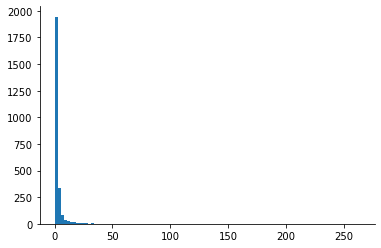

In [6]:
parms_true = np.array([2, 3, 1])
f = loss_model("Burr", ["α", "β", "σ"])
# X= st.burr12(parms_true[1], parms_true[0]).rvs(size = 500) * parms_true[2]
danish = pd.read_csv("Data/danish.csv").x
X = danish.values
plt.hist(X,bins=100)
sns.despine()
α_prior, β_prior, σ_prior = bsm.prior_model('gamma','α', 1, 1), bsm.prior_model('gamma','β', 1, 1), bsm.prior_model('gamma','σ', 1, 1)
prior_single_model = bsm.independent_priors([α_prior, β_prior, σ_prior])

In [7]:
popSize, ρ, c, n_step_max, err, paralell, n_proc, verbose = 2000, 1/2, 0.99, 25, 1e-6, False, 4, True
%time trace, log_marg, DIC, WAIC = bsm.smc_likelihood_annealing(X, f, popSize, prior_single_model, ρ, c,n_step_max, err, paralell, 4, verbose)

Sample generation 0 from the gamma-gamma-gamma prior distribution
Generation: 1 ;temperature: 0.00042629241943359375 ;ESS: 1001 ;steps:4 ;particle moved: 99.95%
Generation: 2 ;temperature: 0.0012758351199408935 ;ESS: 999 ;steps:4 ;particle moved: 99.85000000000001%
Generation: 3 ;temperature: 0.003079988964830511 ;ESS: 1000 ;steps:4 ;particle moved: 99.65%
Generation: 4 ;temperature: 0.006415565403093546 ;ESS: 999 ;steps:4 ;particle moved: 99.05000000000001%
Generation: 5 ;temperature: 0.011838824756433386 ;ESS: 999 ;steps:4 ;particle moved: 99.25%
Generation: 6 ;temperature: 0.020781583491171048 ;ESS: 1000 ;steps:4 ;particle moved: 98.95%
Generation: 7 ;temperature: 0.03558453571539752 ;ESS: 999 ;steps:4 ;particle moved: 99.35000000000001%
Generation: 8 ;temperature: 0.06029765769903088 ;ESS: 999 ;steps:4 ;particle moved: 99.0%
Generation: 9 ;temperature: 0.099204508050789 ;ESS: 1000 ;steps:5 ;particle moved: 99.6%
Generation: 10 ;temperature: 0.16354498961197228 ;ESS: 1000 ;steps:5 ;

-3859.1448366763584 7665.801791978429 7679.348681269672 649.9866858896308


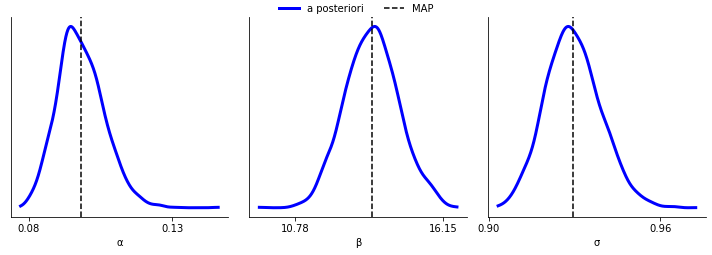

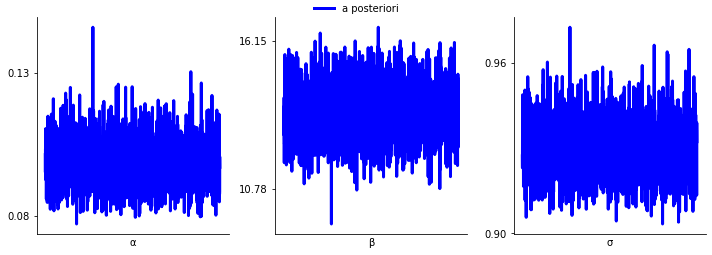

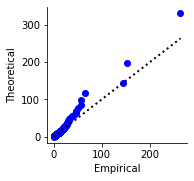

In [8]:
f.set_ppf()
print(log_marg, DIC, WAIC, bsm.compute_Wasserstein(X, f, trace.mean().values, 1))
bsm.posterior_plots(f, trace)
bsm.trace_plots(f, trace)

bsm.qq_plot(X, f, trace.mean().values)

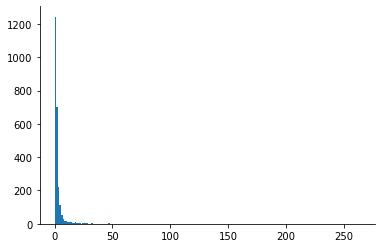

In [9]:
import bayessplicedmodels as bsm
parms_true = np.array([3, 1.5, 1.2,  1, 2, 5, 0.9])
f1, f2 =  bsm.loss_model("Weibull", ["μ1", "λ1"]), bsm.loss_model("Burr", ["α2", "β2", "σ2"])
f = bsm.spliced_loss_model(f1 , f2, "continuous") 
# X= f.sample(parms_true, 1000) 
danish = pd.read_csv("Data/danish.csv").x
X = danish.values
# α1_prior, β1_prior, σ1_prior = bsm.prior_model('gamma','α1', 1, 1), bsm.prior_model('gamma','β1', 1, 1), bsm.prior_model('gamma','σ1', 1, 1)
μ1_prior, λ1_prior = bsm.prior_model('gamma','μ1', 1, 1), bsm.prior_model('gamma','λ1', 1, 1)
α2_prior, β2_prior, σ2_prior = bsm.prior_model('gamma','α2', 1, 1), bsm.prior_model('gamma','β2',1, 1), bsm.prior_model('gamma','σ2', 1, 1)
γ_prior, p_prior =  bsm.prior_model('uniform','γ',min(X), max(X)), bsm.prior_model('uniform', 'p', 0, 1)
prior_spliced_model = bsm.independent_priors([μ1_prior, λ1_prior, α2_prior, β2_prior, σ2_prior, γ_prior])
plt.hist(X,bins=200)
sns.despine()

In [10]:
popSize, ρ, c, n_step_max, err, paralell, n_proc, verbose = 10000, 1/2, 0.99, 25, 1e-6, True, 4, True
%time trace, log_marg, DIC, WAIC = bsm.smc_likelihood_annealing(X, f, popSize, prior_spliced_model, ρ, c,n_step_max, err, paralell, 4, verbose)

Sample generation 0 from the gamma-gamma-gamma-gamma-gamma-uniform prior distribution
Generation: 1 ;temperature: 9.632110595703125e-05 ;ESS: 5000 ;steps:3 ;particle moved: 99.99%
Generation: 2 ;temperature: 0.0007991452271198796 ;ESS: 5003 ;steps:3 ;particle moved: 99.99%
Generation: 3 ;temperature: 0.002245291093843159 ;ESS: 5002 ;steps:3 ;particle moved: 99.96000000000001%
Generation: 4 ;temperature: 0.004164787505379332 ;ESS: 4998 ;steps:3 ;particle moved: 99.98%
Generation: 5 ;temperature: 0.005983464020518539 ;ESS: 5002 ;steps:3 ;particle moved: 99.91%
Generation: 6 ;temperature: 0.008154188770866228 ;ESS: 5000 ;steps:3 ;particle moved: 99.65%
Generation: 7 ;temperature: 0.012273411070108608 ;ESS: 4999 ;steps:3 ;particle moved: 99.53%
Generation: 8 ;temperature: 0.02078200824800684 ;ESS: 4999 ;steps:3 ;particle moved: 99.18%
Generation: 9 ;temperature: 0.035713309292236484 ;ESS: 5000 ;steps:4 ;particle moved: 99.81%
Generation: 10 ;temperature: 0.058549648196686906 ;ESS: 4999 ;st

-3822.6651769627592 7544.176980927432 7552.394237939784 416.50419566930566
μ1    16.425598
λ1     8.415605
α2     1.010788
β2     1.493795
σ2     0.525570
γ      0.920857
dtype: float64


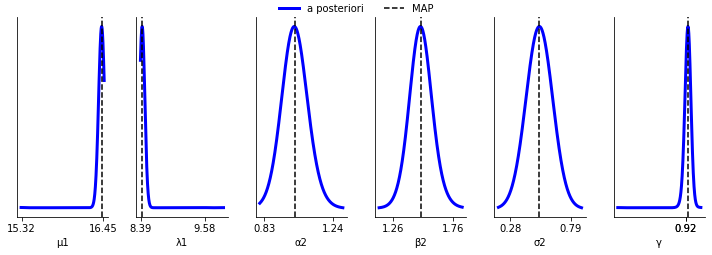

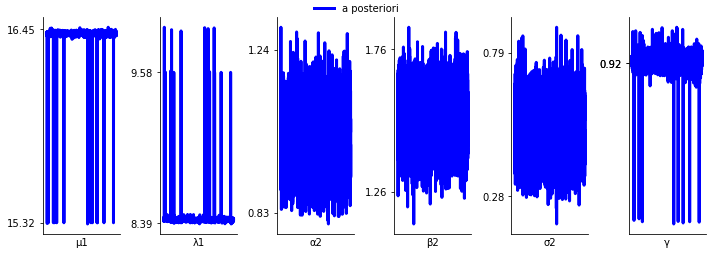

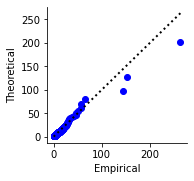

In [11]:
f.set_ppf()
print(log_marg, DIC, WAIC, bsm.compute_Wasserstein(X, f, trace.mean().values, 1))
print(trace.mean())
bsm.posterior_plots(f, trace)
bsm.trace_plots(f, trace)

bsm.qq_plot(X, f, trace.mean().values)

# On the danish fire insurance data set

In [102]:
# The data
danish = pd.read_csv("Data/danish.csv").x
X = danish.values
# Model for the bulk distribution
body_model_names = ["Exp", "Gamma", "Weibull", "Inverse-Gaussian", "Lognormal"]
body_model_param_names = [['λ1'], ["r1", "m1"], ["k1", "β1"], ["μ1", "λ1"], ["μ1", "σ1"]]
# Prior distributions over the parameters of the bulk distribution
body_model_priors= [[bsm.prior_model('gamma',body_model_param_names[0][0], 1, 1)],
                [bsm.prior_model('gamma',body_model_param_names[1][0], 1, 1), bsm.prior_model('gamma',body_model_param_names[1][1], 1, 1)], 
                [bsm.prior_model('gamma',body_model_param_names[2][0], 1, 1), bsm.prior_model('gamma',body_model_param_names[2][1], 1, 1)],
                [bsm.prior_model('gamma',body_model_param_names[3][0], 1, 1), bsm.prior_model('gamma',body_model_param_names[3][1], 1, 1)],
                [bsm.prior_model('normal',body_model_param_names[4][0], 0, 0.5), bsm.prior_model('gamma',body_model_param_names[4][1], 1, 1)]
]

# Model for the tail of the distribution
tail_model_names = ["Burr"]
tail_model_param_names = [["α2", "β2", "σ2"]]

# Prior distributions over the parameters of the bulk distribution
tail_model_priors= [
                [bsm.prior_model('gamma',tail_model_param_names[0][0], 1, 1), bsm.prior_model('gamma',tail_model_param_names[0][1], 1, 1), bsm.prior_model('gamma',tail_model_param_names[0][2], 1, 1)]]
γ_prior, p_prior = bsm.prior_model('uniform', "γ", min(X), max(X)), bsm.prior_model('uniform',"p", 0, 1)

#Splicing model type
splicing_types = ["continuous"]

# Setting the models
fs, f_names, prior_spliced_model = [], [], []
for i in range(len(body_model_names)):
    for j in range(len(tail_model_names)):
        for splicing_type in splicing_types:
            f1, f2 =  bsm.loss_model(body_model_names[i], body_model_param_names[i]), bsm.loss_model(tail_model_names[j], tail_model_param_names[j])
            fs.append(bsm.spliced_loss_model(f1 , f2, splicing_type))
            f_names.append(body_model_names[i] +"-"+ tail_model_names[j]+"-"+splicing_type)
            if splicing_type == "disjoint": 
                prior_spliced_model.append(bsm.independent_priors(body_model_priors[i] + tail_model_priors[j] + [γ_prior, p_prior]))
            else:
                prior_spliced_model.append(bsm.independent_priors(body_model_priors[i] + tail_model_priors[j] + [γ_prior]))    
for f in fs:
    f.set_ppf()
fs_dict = dict(zip(f_names, fs))

In [106]:
popSize, ρ, c, n_step_max, err, paralell, n_proc, verbose = 4000, 1/2, 0.99, 25, 1e-6, False, 4, False
def fit_spliced_models(i):     
        trace, log_marg, DIC, WAIC = bsm.smc_likelihood_annealing(X, fs[i], popSize, prior_spliced_model[i], ρ, c,n_step_max, err, paralell, 4, verbose)
        return([trace, log_marg, DIC, WAIC])
%time res = Parallel(n_jobs=4)(delayed(fit_spliced_models)(i) for i in range(len(f_names)))


Wall time: 11min 51s


In [32]:
fit_spliced_models_dic = dict(zip(f_names, res))
γ_map = np.array([fit_spliced_models_dic[f_names[k]][0]['γ'].mean() for k in range(len(fit_spliced_models_dic))])
spliced_model_df = pd.DataFrame({'model':f_names,
                                 "d": np.array([f.d for f in fs]),
                                 "γ_map": np.array([fit_spliced_models_dic[f_names[k]][0]['γ'].mean() for k in range(len(fit_spliced_models_dic))]),
                                 'log_marg':  np.array([fit_spliced_models_dic[f_names[k]][1] for k in range(len(fit_spliced_models_dic))]), 
                                 "DIC": np.array([fit_spliced_models_dic[f_names[k]][2] for k in range(len(fit_spliced_models_dic))]), 
                                 "WAIC":np.array([fit_spliced_models_dic[f_names[k]][3] for k in range(len(fit_spliced_models_dic))])})
spliced_model_df["posterior_probability"] = np.exp(spliced_model_df["log_marg"] - np.max(spliced_model_df["log_marg"])) / np.sum(np.exp(spliced_model_df["log_marg"] - np.max(spliced_model_df["log_marg"]))) 

spliced_model_df["Wass_dist"] = np.array([bsm.compute_Wasserstein(X, fs_dict[model_name], fit_spliced_models_dic[model_name][0].mean().values, 1) for model_name in spliced_model_df["model"].values])
spliced_model_df.sort_values(by='DIC', ascending=False)

NameError: name 'f_names' is not defined

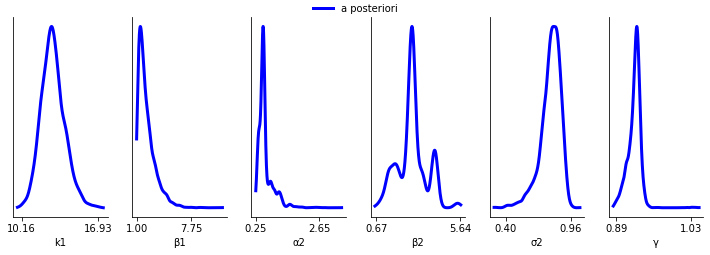

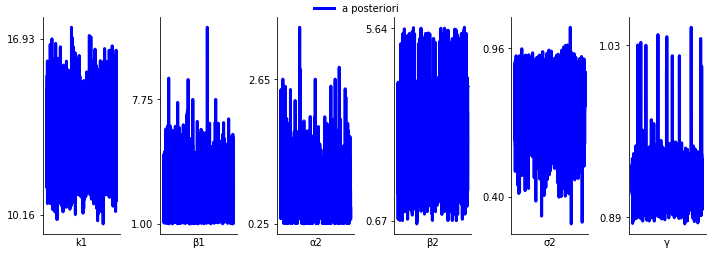

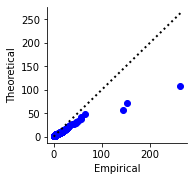

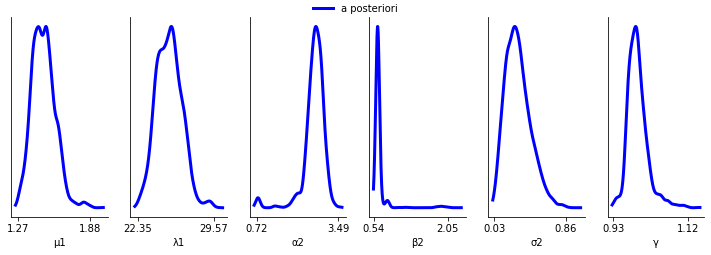

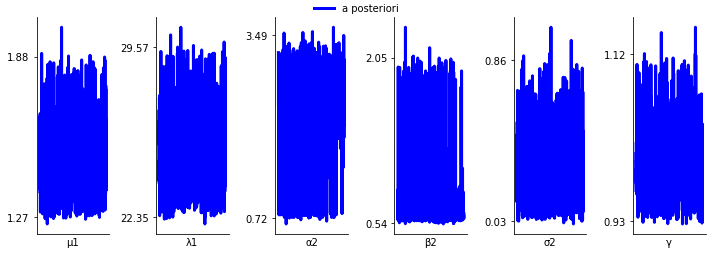

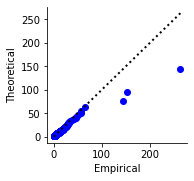

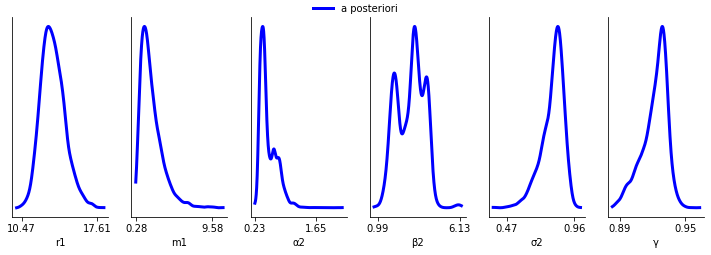

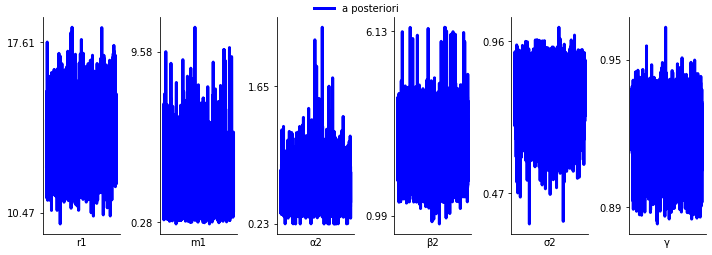

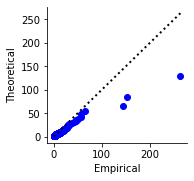

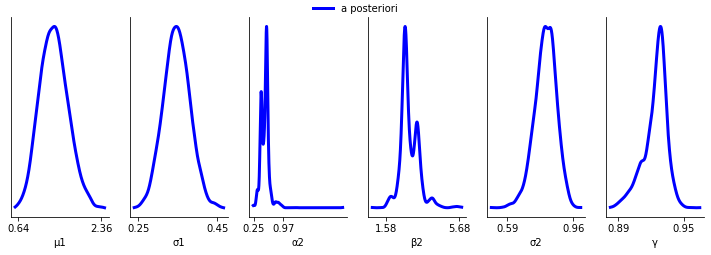

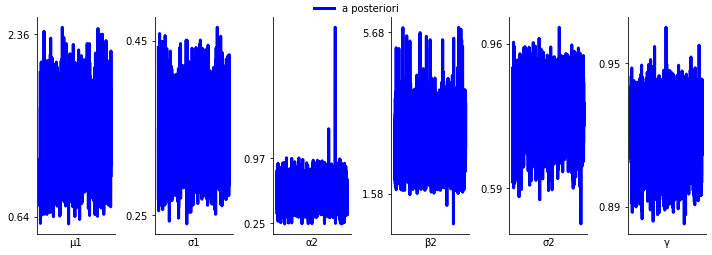

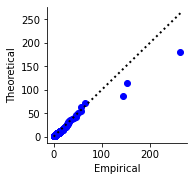

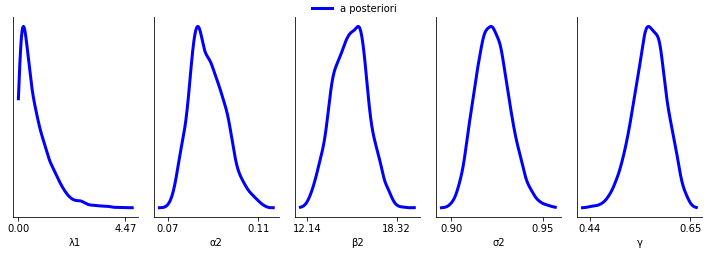

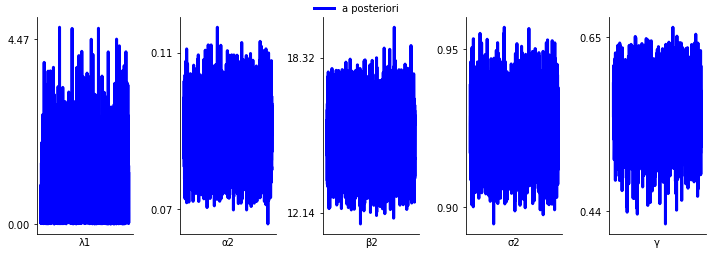

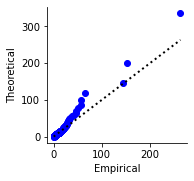

In [108]:
model_names = spliced_model_df.sort_values(by='log_marg', ascending=False)["model"]
for model_name in model_names:
    f, trace = fs_dict[model_name], fit_spliced_models_dic[model_name][0]
    # print(trace.mean().values)
    bsm.posterior_plots(f, trace)
    bsm.trace_plots(f, trace)
    bsm.qq_plot(X, f, trace.mean().values)
